In [ ]:
from scipy.stats import (
    norm, binom, expon, t, chi2, pareto, ttest_ind, sem, beta, laplace
)
from statsmodels.stats.proportion import proportion_confint
import numpy as numpy
from seaborn import distplot
from matplotlib import pyplot
import seaborn
from tqdm import tqdm

import sys
sys.path.append('.')

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def inverse_plot_colorscheme():
    import cycler
    def invert(color_to_convert):
        table = str.maketrans('0123456789abcdef', 'fedcba9876543210')
        return '#' + color_to_convert[1:].lower().translate(table).upper()
    update_dict = {}
    for key, value in pyplot.rcParams.items():
        if value == 'black':
            update_dict[key] = 'white'
        elif value == 'white':
            update_dict[key] = 'black'

    old_cycle = pyplot.rcParams['axes.prop_cycle']
    new_cycle = []
    for value in old_cycle:
        new_cycle.append({
            'color': invert(value['color'])
        })
    pyplot.rcParams.update(update_dict)
    pyplot.rcParams['axes.prop_cycle'] = cycler.Cycler(new_cycle)
    lec = pyplot.rcParams['legend.edgecolor']
    lec = str(1 - float(lec))
    pyplot.rcParams['legend.edgecolor'] = lec

In [ ]:
inverse_plot_colorscheme()

# Лекция 6. Монте-Карло

Сегодня мы поговорим о методе Монте-Карло, являющимся очень мощным инструментом в статистике. С его помощью мы ответим с вами на 3 вопроса:
- Как проверить ваш критерий? Валиден он на практике или нет?
    - Например, работает ли t-test на малых размерах выборок?
- У вас есть 2 разных критерия. Как понять, какой критерий лучше подходит для вашей задачи?
<!-- - Как жить, если мы не знаем теор.вер? Как придумывать критерии на практике, если мы не хотим ничего считатать? В некоторых случаях у вас появится ответ на этот вопрос) -->

## 1. Проверка критериев

С помощью метода Монте-Карло мы в *общем случае* сможем ответить на вопросы:
- **Можно ли использовать данный критерий для нашей задачи?**
- **Верно ли вообще реализован критерий?**

Вся эта глава в первую очередь будет посвящена AB-тестам и как можно проверять критерии для них. Основным критерием для проверки в этой главе станет t-test. Мы с вами:
- Покажем на практике, что t-test работает для выборок не только из нормального распределения
- Посмотрим, как определить, с какого размера выборки можно применять t-test. Как мы помним из прошлой лекции, t-test работает теоретически для выборок из любого распределения, если выборка достаточно большая.


|                          | маленькая выборка | большая выборка |
|--------------------------|-------------------|-----------------|
| нормальное распределение | t-test            | t-test |
| любое распределение      |                   | t-test |

---

Что значит, что критерий корректен? Давайте пойдем от определения.
- Критерий уровня значимости $\alpha$ означает, что вероятность неверно отвергнуть нулевую гипотезу $\le \alpha$.
- А это в свою очередь значит, что если бесконечно много раз повторить один и тот же эксперимент, в котором верна нулевая гипотеза, генерируя заново эксперимент, то число ложноположительных срабатываний будет меньше $\alpha$ процентов.

На самом деле, здесь уже расказана процедура, как проверить ваш критерий :)

0. Создаем код критерия, который мы будем проверять.
1. Генерируем как можно больше экспериментов, где верна $H_0$.
2. Прогоняем на них придуманный критерий.
3. Проверяем, правда ли, что только в $\alpha$ процентов случаев критерий отвергается?

А теперь распишем подробнее:
1. Первым делом надо выбрать распределение, которое будет описывать наши данные. К примеру, если у нас метрика конверсии, то это бернуллевское распределение, а если метрика — выручка, то лучше использовать экспоненциальное распределение в качестве самого простого приближения.

2. Завести счётчик bad_cnt = 0.

3. Далее в цикле размера N, где N — натуральное число от 1000 до бесконечности (чем оно больше, тем лучше):
   - Симулировать создание выборки из распределения, выбранного на первом шаге. Так, чтобы верна была $H_0$.
        - А в случае AB-теста симулировать надо не 1 выборку, а 2: для теста и контроля.

    - Запустить на сгенерированных данных проверяемый критерий.

    - Далее проверить, `pvalue < alpha`. Если да, то увеличить счётчик bad_cnt на 1. Здесь мы проверяем, ошибся ли критерий на текущей симуляции, или нет.

4. Посчитать конверсию bad_cnt / N.
    - Если она примерно совпадает с $\alpha$, то все хорошо.
    - Если она меньше $\alpha$, то в принципе это адекватный критерий на практике, просто он будет менее мощный, чем критерий, который ошибается ровно в $\alpha$ проценте случаев.
        - Но на практике стоит проверить: а теоретически такая ситуация возможна? Или это ошибка в коде критерия?
    - Если критерий ошибается больше, чем в $\alpha$, то значит он некорректен и им нельзя пользоваться. Используя такой критерий, вы будете ошибаться чаще положенного, а значит ваша  компания будет терять больше денег.
    
    
Рассмотрим процедуру на примере: проверим, можно ли использовать t-test для выборок из нормального распределения?

In [ ]:
numpy.random.seed(42)

bad_cnt = 0
N = 10000
alpha=0.05

sample_dist = norm(loc=2, scale=3)
mu0=sample_dist.expect()

# 10 тыс. раз проверяем эксперимент
for i in tqdm(range(N)):
    # Генерирую выборку теста и контроля
    test    = sample_dist.rvs(5)
    control = sample_dist.rvs(5)

    # Запускаю критерий и считаю p-value
    pvalue = ttest_ind(test, control, alternative='two-sided').pvalue

    # Проверяю, что pvalue < alpha
    bad_cnt += (pvalue < alpha)


print(f"FPR: {round(bad_cnt / N, 4)}")

100%|██████████| 10000/10000 [00:22<00:00, 437.70it/s]


FPR: 0.0519


Хм, мы получили, что FPR=0.0519, хотя он должен был равняться 5%. Правда ли, что критерий некорректен? Ну конечно нет, мы просто не учли шум  конверсии: мы вряд ли сможем получить на конечном числе экспериментов точное равенство `FPR=alpha`.

Поэтому надо чуть улучшить 4 шаг:

4. Посчитать полученный FPR и построить доверительный интервал для него. Если $\alpha$ лежит в нем, значит все хорошо, а иначе разбираемся, что пошло не так.
    - Доверительный интервал можно построить разными способами: например, используя идеи построения доверительных интервалов из второй лекции.
    - Но можно сделать проще: в питоне есть функция, которая строит [доверительный интервал Уилсона](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wilson_score_interval): он не такой точный, как мы выводили ранее, зато он более быстрый и работает из "коробки". Его не надо реализовывать самому.

In [ ]:
proportion_confint(count = bad_cnt, nobs = N, alpha=0.05, method='wilson')

(0.04772180742973847, 0.05642233191006188)

Мы видим, что 5% попали в доверительный интервал, а значит мы можем считать, что критерий валиден для нашей задачи.  
  
Если верхняя граница ДИ (5.6%) нас устраивает, то тест нам точно подходит, но вообще и 5.6% вместо 5% погоды не делает

А что, если бы распределение было сложнее?

Расссмотрим пример, когда мат. ожидания в тесте и в контроле равны, но выборки из разных распределений. То есть $H_0$ верна, но распределения разные.

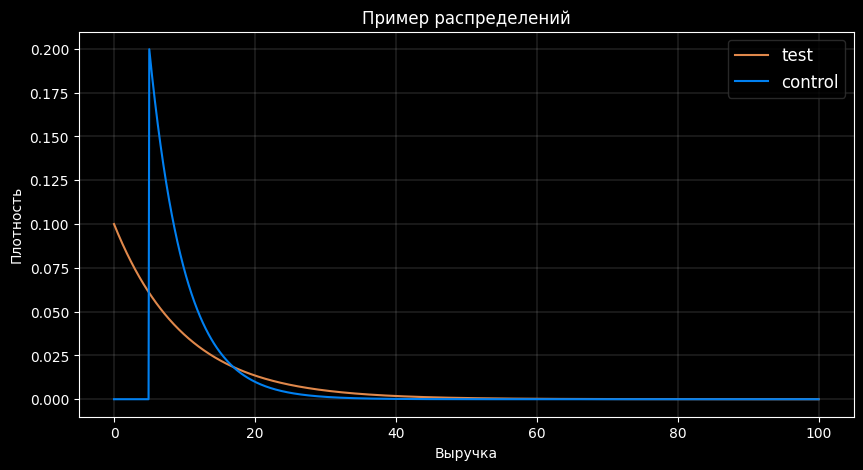

In [ ]:
# У экспоненциального распределение мат. ожидание = scale
test_dist = expon(scale = 10)           # тут оно = 10
control_dist = expon(loc=5, scale = 5)  # а тут 5, сдвинутое на 5 вправо, итого тоже 10

x = numpy.linspace(0, 100, 1000)

pyplot.figure(figsize=(10, 5))
pyplot.title('Пример распределений', fontsize=12)
pyplot.plot(x, test_dist.pdf(x), label='test')
pyplot.plot(x, control_dist.pdf(x), label='control')
pyplot.xlabel('Выручка')
pyplot.ylabel('Плотность')

pyplot.legend(fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.show()

Например, раньше в среднем выручка от пользователя была примерно 10 руб и она была не меньше 5 рублей, а после введения эффекта часть пользователей стала меньше платить, но средний чек остался таким же: 10 руб.

In [ ]:
def check_criterion(test_dist, control_dist, sample_size, N_exps=10000, to_print=True):
    """
        Функция для проверки t-test критерия для AB-теста
        Возвращает доверительный интервал для FPR, если флаг to_print = False. Иначе печатает результат.

        Параметры:
            - test_dist: Распределение тестовой выборки в эксперименте
            - control_dist: Распределение контрольной выборки в эксперименте
            - sample_size: размер выборки теста и контроля
            - N_exps: число экспериментов, по которым потом считается FPR
            - to_print: печатать результат или нет. Если нет, то функция возвращает дов. интервал для FPR.
    """

    numpy.random.seed(35)
    bad_cnt=0
    alpha=0.05

    for i in tqdm(range(N_exps)):
        # Генерирую выборку
        test    = test_dist.rvs(sample_size)
        control = control_dist.rvs(sample_size)

        # Запускаю критерий и считаю p-value
        pvalue = ttest_ind(test, control, equal_var=False, alternative='two-sided').pvalue

        # Проверяю, что pvalue < alpha
        bad_cnt += (pvalue < alpha)

    if to_print:
        print(f"FPR: {round(bad_cnt / N_exps, 4)}")
        print(f"CI={proportion_confint(count = bad_cnt, nobs = N_exps, alpha=0.05, method='wilson')}")
    else:
        return proportion_confint(count = bad_cnt, nobs = N_exps, alpha=0.05, method='wilson')

In [ ]:
check_criterion(test_dist=test_dist, control_dist=control_dist, sample_size=10)

100%|██████████| 10000/10000 [00:18<00:00, 529.64it/s]

FPR: 0.0689
CI=(0.0640994596515586, 0.07403162374363877)


Что ж, мы видим, что t-test не сработал. Истинное $\alpha$ не лежит в доверительном интервале. Но с какого размера выборк t-test начнет работать правильно?

### Как проверить минимальный размер выборки при котором t-test работает?

Для этого давайте просимулируем эксперимент с разным размером выборок и посмотрим, с какого размеры выборки у нас $\alpha$% лежит в дов. интервале.

In [ ]:
scale = numpy.arange(20, 110, 20)
for N in scale:
    left, right = check_criterion(test_dist=test_dist, control_dist=control_dist, sample_size=N, N_exps=10000, to_print=False)
    if left < alpha < right:
        print(f"Min sample size: {N}")
        break

100%|██████████| 10000/10000 [00:18<00:00, 550.44it/s]

Min sample size: 60


In [ ]:
check_criterion(test_dist=test_dist, control_dist=control_dist, sample_size=60)

100%|██████████| 10000/10000 [00:19<00:00, 520.86it/s]

FPR: 0.0527
CI=(0.0484900114917122, 0.05725351345069507)


Так мы видим, что для выборки размера 60 &mdash; 5% уже попали в дов. интервал. Так что мы можем считать, что для таких распределений нам достаточно выборки размера 60, чтобы использовать t-test.

Но надо понимать, что реальный FPR может быть не 5%: он лежит в доверительном интервале (0.045, 0.053). Если нужна большая точность &mdash; нужно провести больше экспериментов (`N_exps -> infinity`)


## Итого

Чтобы проверить критерий, надо уметь много раз проводить один и тот же эксперимент.
- Правильно ли реализорван критерий?
    - Проверьте его! Можно на специально смоделированных данных.
- Можно ли использовать данный критерий для нашей задачи?
    - Проверьте его! Но только нужно **правильно** сгенерировать эксперимент.
- Как найти минимальный размер выборки у t-test?
    - Прверьте t-test на разных размерах выборки. С того момента, как $\alpha$% лежит в доверительном интервале &mdash; можем считать, что t-test будет работать.


# Как смоделировать эксперимент?

Есть 2 ответа на этот вопрос:
1. Генерация теста и контроля через искусственное моделирование. С помощью разных распределений можно попытаться приблизить реальное распределение на данных. Например:
    - Для генерации выручки использовать экспоненциальное распределение. Чем больше выручка от пользователя &mdash; тем меньше таких людей.
    - Для генерации конверсионных выборок (например, кликнет/не клинкет) использовать бернуллиевскую выборку.
    - Иногда можно брать смесь распределений: пусть 90% пользователй нашего сайта приносят нулевую выручку. Тогда можно перемножить бернуллиевское распределение на экспоненциальное для моделирования выручки от пользователя.
    - Также для проверки криетрия не обязательно распределения в тесте и в контроле должны совпадать. Для проверки критерия равенства средних не обязательно должны совпадать распределения в тесте и в контроле. Они могут быть разными, но мат. ожидание совпадет, как было в примере выше.
    
---     
    
2.  Датасеты на исторических данных компании. У многих компаний есть логирование событий. Тогда мы сможем прямо на реальных данных оценить работоспособность критерия! И не попасться в ловушку того, что на искуственных выборках критерий валиден, а на реальных данных нет. Например, у нас есть данные о транзакциях пользователей за несколько лет. Это уже один готовый датасет: вы делите всех пользователей на тест и контроль и получаете один «эксперимент» для проверки вашего критерия.

Осталось понять, как из одного большого датасета сделать N маленьких датасетов. Я расскажу, как мы это делаем в Авито, но описанная механика применима практически к любой компании.

Наши пользователи размещают объявления. Каждое объявление относится только к одной категории товаров и размещено только в одном регионе. Отсюда возникает незамысловатый алгоритм:

 - Разобьём все размещения пользователей на четыре (или N в общем случае) категории: автомобили, спецтехника, услуги и недвижимость. Теперь наш датасет можно разбить на эти подкатегории: к примеру, в одном датасете смотреть выручку пользователя только в этой подкатегории.

 - Поделим датасеты по месяцам: датасет трат пользователя за ноябрь, за декабрь и так далее.

 - Ещё все метрики можно поделить по субъектам РФ или по группе субъектов: датасет трат пользователя из Москвы, датасет трат пользователя из Хабаровска и так далее.

 - Объедним все 3 правила в одно. Например: датасет трат пользователя в Авто за ноябрь в Москве.

 - Теперь у нас есть большое число датасетов и в каждом из них есть пользователи. Поделим пользователей случайно на тест и контроль и получим финальные датасеты для валидации придуманных статистических критериев.

Давайте посмотрим на картинках, как такая схема увеличивает количество датасетов:
    <img src="https://habrastorage.org/getpro/habr/upload_files/71a/497/8cb/71a4978cbbb1f177c5edb360456f3e90.png" width="1500" height="200" />


Здесь мы смогли разбить 1 датасет на 16 датасетов. А если добавить ещё и разделение по субъектам РФ, которых больше 80, то мы получим уже 16×80 = 1280 датасетов для проверки. И это всего за 5 месяцев! При этом, как показывает практика, 1000 датасетов достаточно, чтобы отделить некорректный критерий от хорошего.

**Сравним 2 метода**

Главные плюсы искусственных данных в том, что их сколько угодно, они генерируются быстро, и вы полностью контролируете распределение. Можно создать бесконечно много датасетов и очень точно оценить ошибку первого рода вашего критерия. Также, мой опыт говорит, что на начальных этапах дебага нового критерия искусственные данные сильно лучше реальных. Главный минус — вы получили корректность вашего критерия только на искусственных данных! На реальных же данных критерий может работать некорректно.

У датасетов, полученных на настоящих данных, всё наоборот: собрать большое количество датасетов сложно, да и не всегда нормально построен процесс сбора логов. Но адекватная оценка корректности критерия для проверки гипотез в вашей компании возможна только таким способом. Всегда можно реализовать такой критерий, который будет правильно работать на искусственных данных. Но, столкнувшись в реальности с более шумными данными, он может начать ошибаться чаще, чем в 5% случаев. Поэтому важно убедиться, что именно на настоящих данных метод будет работать верно.


----------

Посмотрим еще раз на табличку:

|                          | маленькая выборка | большая выборка |
|--------------------------|-------------------|-----------------|
| нормальное распределение | t-test            | t-test |
| любое распределение      |                   | t-test |


Мы уже поняли, как отличить маленькую выборку от большой. Но остался последний вопрос: чем заполнить последнюю пустующую ячейку?

### Можно ли использовать t-test, если выборка мала и не из нормального распределения?


На самом деле ответ простой: проверьте критерий на интересующем вас размере выборки: если FPR $\leq \alpha$ значит все хорошо, а если нет &mdash; критерий использовать нельзя.


|                          | маленькая выборка | большая выборка |
|--------------------------|-------------------|-----------------|
| нормальное распределение | t-test               | t-test|
| любое распределение      | Монте-Карло проверка | t-test |


Например, в случае выше с двумя экспоненциальными распределениями &mdash; нельзя. А если бы ошибка была бы меньше 5% то можно. Например:

In [ ]:
test_dist    = expon(scale=20)
control_dist = expon(scale=20)

check_criterion(test_dist=test_dist, control_dist=control_dist, sample_size=10)

FPR: 0.0396
CI=(0.03595116606388123, 0.04360241963583777)


Здесь FPR стат. значимо меньше 5%, а значит использовать t-test **можно**. Только надо быть готовым, что он будет не очень мощным.

---

## 2. Какой критерий лучше?

Пусть у вас есть 2 критерия, и оба валидны на наших данных. Как понять на практике, какой из них лучше?

Правильный ответ &mdash; надо сравнить мощность 2 критериев! Но как ее узнать?

Предлагается повторить ту же процедуру, что мы делали выше, только вместо генерации эксперимента, когда верна $H_0$, генерировать эксперимент, когда верна альтернатива. В случае сравнения средних &mdash; надо добавить эффект к тесту. И вместо FPR считать TPR &mdash; сколько раз мы отвергли нулевую гипотезу. Чем больше &mdash; тем лучше.

Точно также проверим на t-test.

In [ ]:
numpy.random.seed(42)

rej_cnt = 0
N = 10000
alpha=0.05

sample_dist = norm(loc=2, scale=3)
mu=sample_dist.expect()

for i in range(N):
    # Генерирую выборку теста и контроля
    test    = sample_dist.rvs(15)
    control = sample_dist.rvs(15) * 2

    # Запускаю критерий и считаю p-value
    pvalue = ttest_ind(test, control, equal_var=False, alternative='two-sided').pvalue

    # Проверяю, что pvalue < alpha
    rej_cnt += (pvalue < alpha)


print(f"TPR или мощность: {round(rej_cnt / N, 4)}")

TPR или мощность: 0.1938


Видим, что мощность критерия в данном случае раняется 19%. Если есть второй критерий &mdash; надо запустить такую проверку для 2го критерия и оценить, какой критерий лучше или хуже, не забыв о стат. значимости. Подробнее вы рассмотрите эту процедуру в домашнем задании.

Еще есть вопрос: вы оценили 2 критерия лишь при добавлении одного эффекта, например в случае выше, когда $\mu_T = \mu_C * 2$. А если бы было другое изменение, сохранились бы результаты, что этот критерий лучше? Не факт, поэтому поэтому надо идеалогически подбирать такой эффект, который чаще всего встретится на практике. Поэтому ваша задача еще верно сымитировать эффект, похожий на настоящий.
Логика здесь точно такая же, как и почему лучше генерировать эксперименты на исторических данных, а не на настоящих.

То есть, ваша задача для оценки мощности критерия состоит в:
1. Создании 1000 экспериментов, на исторических данных, или на симулированных
2. Подборе эффекта, который будет лучше всего имитировать истинный проверяемый эффект в гипотезе.


----

# Итог

В чем заключается метод Монте-Карло в каждой из секции? В генерации большого количества экспериментов и подсчета каких-то статистик на нем.
На текущей лекции мы с вами посмотрели разные способы применения Монте-Карло метода:
- Как проверять критерий на практике.
    - Как генерировать эксперименты для проверки
- Как оценивать мощность критерия.
<!-- - И как самому приудмать свой критерий, не заниаясь сложной математикой. Метод хороший, но не всегда рабочий. -->
